In [1]:
import numpy as np
import xarray as xr

import scipy
import h3
from h3.unstable import vect  # used for hexgrid vectorization

import json
import pickle

from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
import cartopy as cart

import h3_tools

/nethome/4302001/miniconda3/lib/python3.9/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


# Define the release domain
First define a release domain. You do not need to worry about land yet, as we'll filter this out. You can define a dictionary in geoJSON style, for example using https://geojson.io/#map=1.77/17.4/-63/8.8/18. You may need to extract some of the inner elements of the geoJSON so that you have something that looks like the below.

In [2]:
Atlantic = {
      "type": "Polygon",
      "coordinates": [
          [[  -74.1361810961009, 48.373792170946786],
          [  -67.33533744590342, 47.65387298440368],
          [  -65.55986632011246, 45.9792437876242],
          [  -72.02719847958402, 44.53104524798408],
          [  -71.16038684142649, 41.86644013062025],
          [  -76.86924090652485, 40.74587733806143],
          [  -77.86752937901312, 35.71245307084121],
          [  -82.36371712191027, 31.645160248279296],
          [  -97.24514351293215, 29.94573639618241],
          [  -99.85186776358252, 24.233602091358847],
          [  -95.92885990389013, 18.127482590027228],
          [  -89.3600396690473, 15.572266600672307],
          [  -84.28781886784049, 14.773744110986144],
          [  -83.8388055635338, 10.191292463555811],
          [  -81.31510031795777, 8.235007092105846],
          [  -79.25416134594884, 9.35523938640442],
          [  -78.14328505258835, 8.761611821374913],
          [  -77.73830373563413, 7.875396003538171],
          [  -75.19484080994795, 7.552831906919053],
          [  -36.53076821160431, -8.925436070859305],
          [  -72.02020616528678, -46.68931246995514],
          [  -67.97290461351264, -55],
          [  20, -55],
          [  20, -14],
          [  18.97436692646147, -11.917217920873952],
          [  9.127087807805538, 7.59492557772019],
          [  -8.91416344160237, 6.93366511454127],
          [  -15.067201051501996, 15.752353747499669],
          [  -11.178000956607491, 25.063512467505575],
          [  -5.7894560628897125, 36.836870844581625],
          [  12.93209197140203, 52.900934983799374],
          [  14.448383948559325, 65],
          # [  -61.38021334416041, 60],
          # [  -66.64123170764944, 60],
          [  -65.21821112783054, 65],
          [  -74.1361810961009, 48.373792170946786]
          ]
        ]}

Uber H3 flips the geoJSON lon-lat order, so for the particle initialization, we flip the two as well. Below we use list comprehension to make a similar object as above, but with lons and lats switched.

In [3]:
Atlantic_flipped = {
      "type": "Polygon",
      "coordinates": [[[lat, lon] for lon, lat in Atlantic["coordinates"][0]]]}

We can visualize this shape using matplotlib.

In [4]:
atl_shape = shape(Atlantic)

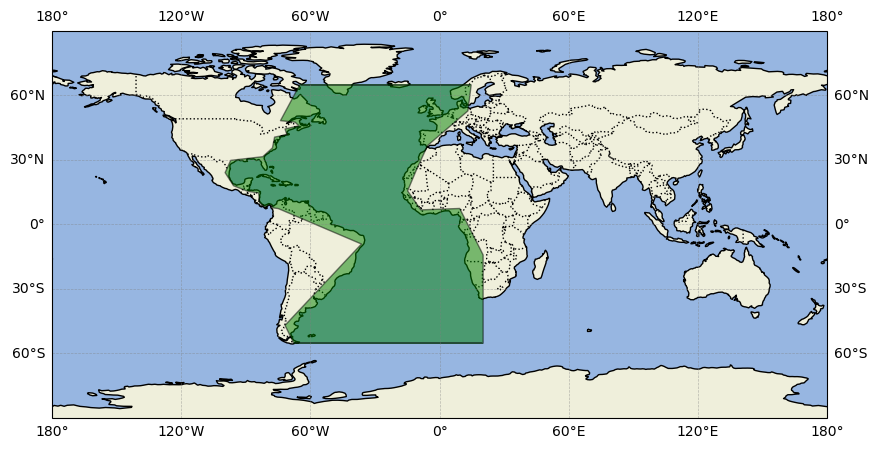

In [5]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)
ax.add_geometries([atl_shape], cart.crs.PlateCarree(), facecolor='green', edgecolor='black', alpha=0.5)

plt.show()

# Create h3 particles

Create a set of particles using `h3_tools.initGrid`.

In [6]:
AtlanticParticles = h3_tools.initGrid(Atlantic_flipped, h3_res=5)

Let's plot the particles and the original generating shape.

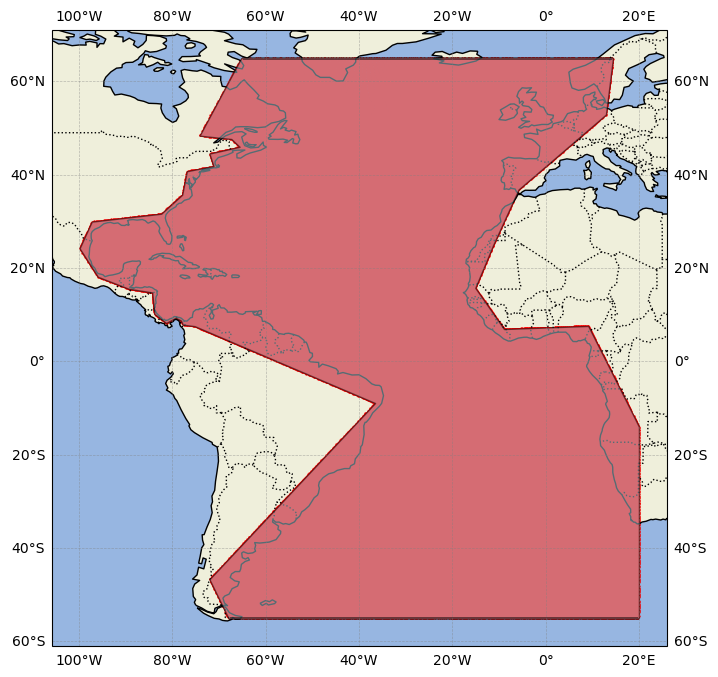

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(AtlanticParticles.centroid_lons, AtlanticParticles.centroid_lats, transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([atl_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)


plt.show()

# Mask particles on land

Now we load in a mask to get rid of particles that are on land.

In [8]:
mask = xr.open_dataset("/nethome/4302001/data/input_data/MOi/domain_ORCA0083-N006/PSY4V3R1_mask.nc").isel(t=0).isel(x=slice(2250, 3700), y=slice(500, 2800))

In [9]:
full_water =(mask.tmask.isel(z=0).astype(bool) * mask.umask.isel(z=0).astype(bool) * mask.vmask.isel(z=0).astype(bool) * mask.fmask.isel(z=0).astype(bool))

In [10]:
AtlanticParticles.mask(mask.nav_lon, mask.nav_lat, full_water)

Let's plot the particles again!

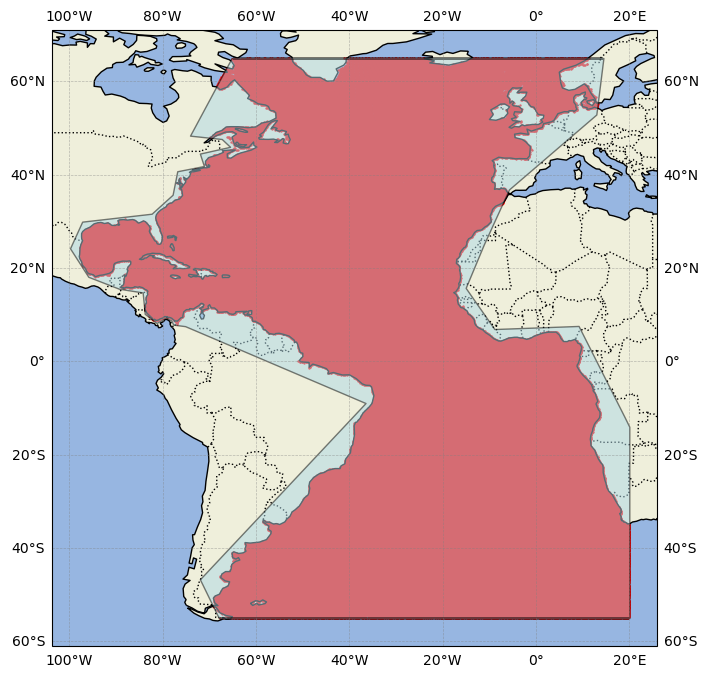

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.add_feature(cart.feature.LAND)
ax.add_feature(cart.feature.OCEAN)
ax.add_feature(cart.feature.COASTLINE)
ax.add_feature(cart.feature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5, linewidth=0.5)

ax.scatter(AtlanticParticles.centroid_lons, AtlanticParticles.centroid_lats, transform=cart.crs.PlateCarree(), s=0.5, c='r')
ax.add_geometries([atl_shape], cart.crs.PlateCarree(), facecolor='lightblue', edgecolor='black', alpha=0.5)


plt.show()

In [15]:
print(f"Number of particles: {AtlanticParticles.size}")

Number of particles: 321531


# Save the result

You can now use `AtlanticParticles.centroid_lons` and `AtlanticParticles.centroid_lats` to create any particle set. If you want to save the particles as a pickled dictionary for later use, see the code below. You may also pickle the `AtlanticParticles` object directly, but only saving the positions maximizes compatibility.

In [13]:
with open("Atlantic_h3_res5_lonlat_dict.pickle", "wb") as dumpFile:
    pickle.dump(AtlanticParticles.lonlat_dict, dumpFile)